## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:

from pathlib import Path

if os.name == 'nt':
    path = str(Path.home()) + "\\data\\ml-latest-small\\"
else:
    path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [5]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [6]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [7]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [8]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2, use_wd_sched=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.81203  0.82221]                                                                                           
[ 1.       0.67639  0.85878]                                                                                           
[ 2.       0.32561  0.81591]                                                                                           



Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [9]:
math.sqrt(0.776)

0.8809086218218096

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [10]:
preds = learn.predict()

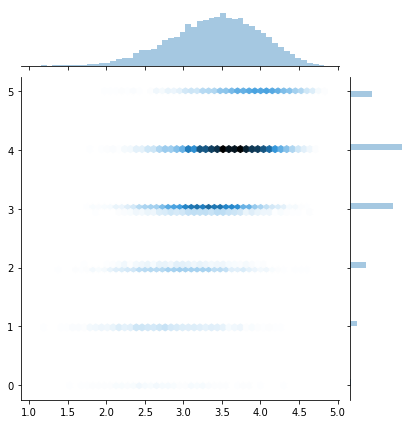

In [11]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [12]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [13]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [14]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [15]:
movie_bias

array([[ 0.51824],
       [ 0.60274],
       [ 0.85465],
       ..., 
       [ 0.27087],
       [ 0.05813],
       [ 0.21673]], dtype=float32)

In [16]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [17]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.56495059, 'Battlefield Earth (2000)'),
 (-0.51489735, 'Anaconda (1997)'),
 (-0.49133098, 'Wild Wild West (1999)'),
 (-0.46594277, 'Inspector Gadget (1999)'),
 (-0.46191511, 'Batman & Robin (1997)'),
 (-0.45754486, "Big Momma's House (2000)"),
 (-0.44192806, 'Super Mario Bros. (1993)'),
 (-0.42421135, "Joe's Apartment (1996)"),
 (-0.41399151, 'Avengers, The (1998)'),
 (-0.40731966, 'Dungeons & Dragons (2000)'),
 (-0.40664127, 'Blame It on Rio (1984)'),
 (-0.39929089, '102 Dalmatians (2000)'),
 (-0.3910113, 'Flintstones, The (1994)'),
 (-0.38912228, 'Police Academy 3: Back in Training (1986)'),
 (-0.38864005, 'Speed 2: Cruise Control (1997)')]

In [18]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.56495059, 'Battlefield Earth (2000)'),
 (-0.51489735, 'Anaconda (1997)'),
 (-0.49133098, 'Wild Wild West (1999)'),
 (-0.46594277, 'Inspector Gadget (1999)'),
 (-0.46191511, 'Batman & Robin (1997)'),
 (-0.45754486, "Big Momma's House (2000)"),
 (-0.44192806, 'Super Mario Bros. (1993)'),
 (-0.42421135, "Joe's Apartment (1996)"),
 (-0.41399151, 'Avengers, The (1998)'),
 (-0.40731966, 'Dungeons & Dragons (2000)'),
 (-0.40664127, 'Blame It on Rio (1984)'),
 (-0.39929089, '102 Dalmatians (2000)'),
 (-0.3910113, 'Flintstones, The (1994)'),
 (-0.38912228, 'Police Academy 3: Back in Training (1986)'),
 (-0.38864005, 'Speed 2: Cruise Control (1997)')]

In [19]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(0.85464656, 'Shawshank Redemption, The (1994)'),
 (0.64189768, 'Godfather, The (1972)'),
 (0.60823715, 'Usual Suspects, The (1995)'),
 (0.60663605, 'Princess Bride, The (1987)'),
 (0.60274202, 'Pulp Fiction (1994)'),
 (0.58976173, 'To Kill a Mockingbird (1962)'),
 (0.58829743, "Schindler's List (1993)"),
 (0.58685285, 'Godfather: Part II, The (1974)'),
 (0.58328331, 'Silence of the Lambs, The (1991)'),
 (0.5740205, 'Monty Python and the Holy Grail (1975)'),
 (0.56659067, 'Fugitive, The (1993)'),
 (0.56491357, 'Last Emperor, The (1987)'),
 (0.55882591, 'Matrix, The (1999)'),
 (0.55822492, 'American Beauty (1999)'),
 (0.55809182, 'Fargo (1996)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [20]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [22]:
movie_pca.shape

(3, 3000)

In [23]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [24]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06469176, 'Godfather, The (1972)'),
 (0.05986831, 'Chinatown (1974)'),
 (0.059065066, 'Godfather: Part II, The (1974)'),
 (0.056968633, 'Usual Suspects, The (1995)'),
 (0.055805687, 'African Queen, The (1951)'),
 (0.052852165, 'On the Waterfront (1954)'),
 (0.0526191, 'Vertigo (1958)'),
 (0.049663004, 'Philadelphia Story, The (1940)'),
 (0.049396344, 'Raging Bull (1980)'),
 (0.04911438, 'Psycho (1960)')]

In [25]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.045414664, 'Anaconda (1997)'),
 (-0.044002037, 'Jack Frost (1998)'),
 (-0.040415052, 'Battlefield Earth (2000)'),
 (-0.039584279, 'Police Academy 3: Back in Training (1986)'),
 (-0.039137721, 'Green Lantern (2011)'),
 (-0.038734805, 'Karate Kid, Part III, The (1989)'),
 (-0.03823394, 'Jaws 3-D (1983)'),
 (-0.037625354, 'Home Alone 3 (1997)'),
 (-0.036249213, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.034897909, "Joe's Apartment (1996)")]

In [26]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [27]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.060802467, 'Patch Adams (1998)'),
 (0.058448695, 'Sherlock Holmes (2009)'),
 (0.055671025, 'Entrapment (1999)'),
 (0.054392923, 'Sweet Home Alabama (2002)'),
 (0.054296128, '50 First Dates (2004)'),
 (0.053169098, 'Armageddon (1998)'),
 (0.052301206, 'Gladiator (2000)'),
 (0.05219876,
  "Monty Python's And Now for Something Completely Different (1971)"),
 (0.051801194, 'Anchorman 2: The Legend Continues (2013)'),
 (0.051735047, 'Lilo & Stitch (2002)')]

In [28]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.051485952, 'Limey, The (1999)'),
 (-0.046536099, 'Hearts of Darkness: A Filmmakers Apocalypse (1991)'),
 (-0.04606567, 'Fearless (1993)'),
 (-0.044642895, 'What Ever Happened to Baby Jane? (1962)'),
 (-0.044410415, 'Jingle All the Way (1996)'),
 (-0.044242531, 'Andalusian Dog, An (Chien andalou, Un) (1929)'),
 (-0.043810725, '8 1/2 (8½) (1963)'),
 (-0.043394655, 'Brokeback Mountain (2005)'),
 (-0.042403493, 'Thirty-Two Short Films About Glenn Gould (1993)'),
 (-0.041916016, '2001: A Space Odyssey (1968)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

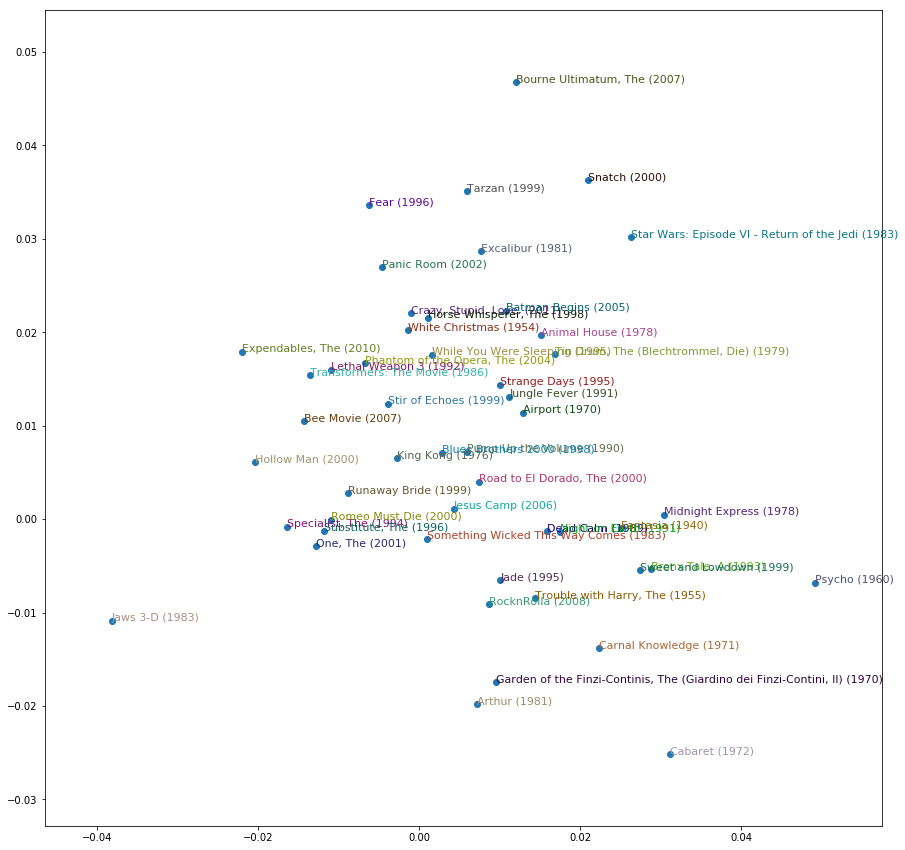

In [29]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [31]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [32]:
a*b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [33]:
(a*b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [34]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [35]:
model=DotProduct()

In [36]:
model(a,b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### Dot product model

In [37]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [38]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [39]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [40]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [41]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [42]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.68052  1.64623]                                                                                           
[ 1.       1.11182  1.3017 ]                                                                                           
[ 2.       0.92113  1.22625]                                                                                           



In [43]:
set_lrs(opt, 0.01)

In [44]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.69481  1.14847]                                                                                           
[ 1.       0.68183  1.13478]                                                                                           
[ 2.       0.71034  1.13098]                                                                                           



### Bias

In [45]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [46]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [47]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [48]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.83337  0.84072]                                                                                           
[ 1.       0.81233  0.81566]                                                                                           
[ 2.       0.7973   0.81089]                                                                                           



In [49]:
set_lrs(opt, 1e-2)

In [50]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.72237  0.8042 ]                                                                                           
[ 1.       0.75235  0.80283]                                                                                           
[ 2.       0.73483  0.80159]                                                                                           



### Mini net

In [51]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [52]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [53]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.91222  0.81967]                                                                                           
[ 1.       0.81384  0.78872]                                                                                           
[ 2.       0.77347  0.78591]                                                                                           



In [54]:
set_lrs(opt, 1e-3)

In [55]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.77559  0.79019]                                                                                           
[ 1.       0.77028  0.78877]                                                                                           
[ 2.       0.73408  0.79226]                                                                                           

